In [50]:
import pandas as pd
import swifter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 5]


In [21]:
df = pd.read_csv("./Data/Part 1 - Telemarketing.csv")

In [22]:
df = pd.concat([df, pd.get_dummies(df.outcome, prefix='outcome').astype(int)], axis=1)
df = pd.concat([df, pd.get_dummies(df.prev_outcome, prefix='prev_outcome').astype(int)], axis=1)

## Exercise 1: inspecting the data

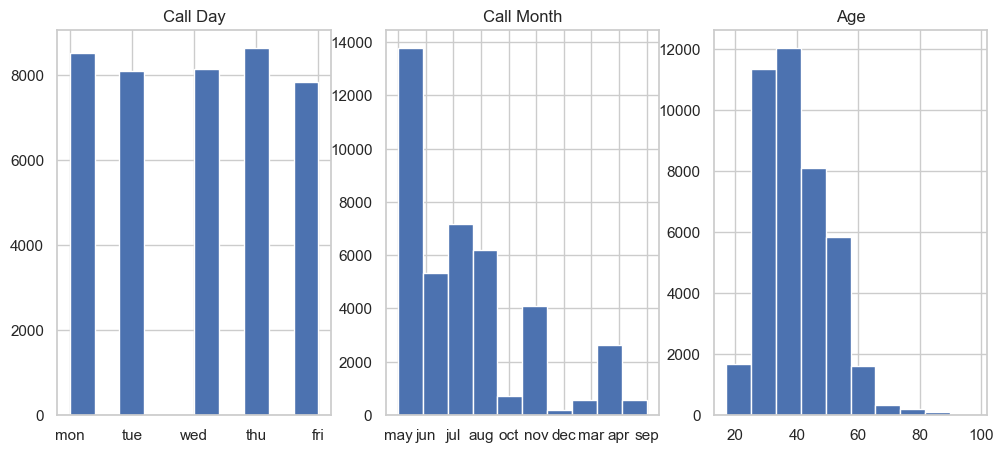

In [ ]:
descriptives = df.describe(include='all')

summary_stats = {
    'total_calls': len(df),
    'success_rate': descriptives.outcome_yes['mean'],
    'age_mean': descriptives.age['mean'],
    'age_min': descriptives.age['min'],
    'age_max': descriptives.age['max'],
    'top_day': descriptives.call_day['top'],
    'top_month': descriptives.call_month['top'],
}


fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
df.call_day.hist(ax=ax1)
ax1.set_title('Call Day')
df.call_month.hist(ax=ax2)
ax2.set_title('Call Month')
df.age.hist(ax=ax3)
ax3.set_title('Age')
plt.show()



In [49]:
pd.DataFrame(summary_stats.values(), index=summary_stats.keys(), columns=['Value'])


,Value
total_calls,41188
success_rate,0.112654
age_mean,40.02406
age_min,17.0
age_max,98.0
top_day,thu
top_month,may


What additional variables would you like to have about the client, the phone call, or other details
for performing this analysis? Why? Describe your answer briefly (max 100 words).

Call duration - To analyze if longer conversations correlate with success
Time of day - Customer availability patterns could vary significantly
Number of products already owned - Existing relationship depth might affect success
Income level - Financial capacity could influence purchase decisions
Last contact date - Frequency of contact might impact response

## 2

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Split features and target
X = df.drop(['outcome', 'outcome_no', 'outcome_yes'], axis=1)
y = df['outcome_yes']

# Split data with 66% training, 34% test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.66, random_state=42)

# Create overfitted tree (equivalent to REPTree settings)
tree = DecisionTreeClassifier(
    max_depth=None,  # -1 in Weka
    min_samples_split=2,  # minimum 1.0 in Weka
    min_samples_leaf=1,
    ccp_alpha=0.001,  # similar to minVarianceProp
    random_state=42
)

# Fit the model
tree.fit(X_train, y_train)

# Get accuracy scores
train_score = tree.score(X_train, y_train)
test_score = tree.score(X_test, y_test)

print(f"Training accuracy: {train_score:.4f}")
print(f"Test accuracy: {test_score:.4f}")


ValueError: could not convert string to float: 'admin.'